<a href="https://colab.research.google.com/github/DharmeshPatel33/Land-Cover-Classification-using-Hyper-Spectral-Data-with-Deep-Learning/blob/main/CNN_Hybrid_Spectral_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install spectral

     |████████████████████████████████| 215kB 5.4MB/s 


In [ ]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os
import spectral

init_notebook_mode(connected=True)
%matplotlib inline

# Data Loading

In [ ]:
## GLOBAL VARIABLES
dataset = 'IP'
test_ratio = 0.7
windowSize = 25

##Drive Path

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
print(os.path.join('gdrive/My Drive/','HIS_Final/data'))
#loadData('IP')

gdrive/My Drive/HIS_Final/data


In [ ]:
def loadData(name):
    data_path = os.path.join('gdrive/My Drive/HIS_Final','data')
    if name == 'IP':
        data = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
    elif name == 'SA':
        data = sio.loadmat(os.path.join(data_path, 'Salinas_corrected.mat'))['salinas_corrected']
        labels = sio.loadmat(os.path.join(data_path, 'Salinas_gt.mat'))['salinas_gt']
    elif name == 'PU':
        data = sio.loadmat(os.path.join(data_path, 'PaviaU.mat'))['paviaU']
        labels = sio.loadmat(os.path.join(data_path, 'PaviaU_gt.mat'))['paviaU_gt']
    
    return data, labels

In [ ]:
def splitTrainTestSet(X, y, testRatio, randomState=345):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testRatio, random_state=randomState,
                                                        stratify=y)
    return X_train, X_test, y_train, y_test

In [ ]:
def applyPCA(X, numComponents=75):
    newX = np.reshape(X, (-1, X.shape[2]))
    pca = PCA(n_components=numComponents, whiten=True)
    newX = pca.fit_transform(newX)
    newX = np.reshape(newX, (X.shape[0],X.shape[1], numComponents))
    return newX, pca

In [ ]:
def padWithZeros(X, margin=2):
    newX = np.zeros((X.shape[0] + 2 * margin, X.shape[1] + 2* margin, X.shape[2]))
    x_offset = margin
    y_offset = margin
    newX[x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, :] = X
    return newX

In [ ]:
def createImageCubes(X, y, windowSize=5, removeZeroLabels = True):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [ ]:
X, y = loadData(dataset)

X.shape, y.shape

((145, 145, 200), (145, 145))

In [ ]:
K = X.shape[2]

In [ ]:
K = 30 if dataset == 'IP' else 15
X,pca = applyPCA(X,numComponents=K)

X.shape

(145, 145, 30)

In [ ]:
X, y = createImageCubes(X, y, windowSize=windowSize)

X.shape, y.shape

((10249, 25, 25, 30), (10249,))

In [ ]:
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, test_ratio)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((3074, 25, 25, 30), (7175, 25, 25, 30), (3074,), (7175,))

Xtrain, Xvalid, ytrain, yvalid = splitTrainTestSet(Xtrain, ytrain, 0.3333)

Xtrain.shape, Xvalid.shape, ytrain.shape, yvalid.shape

# Model and Training

In [ ]:
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, K, 1)
Xtrain.shape

(3074, 25, 25, 30, 1)

In [ ]:
ytrain = np_utils.to_categorical(ytrain)
ytrain.shape

(3074, 16)

Xvalid = Xvalid.reshape(-1, windowSize, windowSize, K, 1)
Xvalid.shape

yvalid = np_utils.to_categorical(yvalid)
yvalid.shape

In [ ]:
S = windowSize
L = K
output_units = 9 if (dataset == 'PU' or dataset == 'PC') else 16

In [ ]:
## input layer
input_layer = Input((S, S, L, 1))

## convolutional layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
print(conv_layer3.shape)
conv3d_shape = conv_layer3.shape
conv_layer3 = Reshape((conv3d_shape[1], conv3d_shape[2], conv3d_shape[3]*conv3d_shape[4]))(conv_layer3)
conv_layer4 = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(conv_layer3)

flatten_layer = Flatten()(conv_layer4)

## fully connected layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=output_units, activation='softmax')(dense_layer2)

(None, 19, 19, 18, 32)


In [ ]:
# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)

In [ ]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 25, 25, 30, 1)]   0         
_________________________________________________________________
conv3d_12 (Conv3D)           (None, 23, 23, 24, 8)     512       
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 21, 21, 20, 16)    5776      
_________________________________________________________________
conv3d_14 (Conv3D)           (None, 19, 19, 18, 32)    13856     
_________________________________________________________________
reshape (Reshape)            (None, 19, 19, 576)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 17, 17, 64)        331840    
_________________________________________________________________
flatten (Flatten)            (None, 18496)            

In [ ]:
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [ ]:
# checkpoint
filepath = "gdrive/My Drive/HIS_Final/best-model.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [ ]:
history = model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=15, callbacks=callbacks_list)

Epoch 1/15
13/13 [==============================] - 202s 16s/step - loss: 0.0140 - accuracy: 0.9945
Epoch 2/15
13/13 [==============================] - 200s 15s/step - loss: 0.0219 - accuracy: 0.9935
Epoch 3/15
13/13 [==============================] - 200s 15s/step - loss: 0.0176 - accuracy: 0.9941
Epoch 4/15
13/13 [==============================] - 199s 15s/step - loss: 0.0166 - accuracy: 0.9945
Epoch 5/15
13/13 [==============================] - 199s 15s/step - loss: 0.0192 - accuracy: 0.9938
Epoch 6/15
13/13 [==============================] - 200s 15s/step - loss: 0.0145 - accuracy: 0.9961
Epoch 7/15
13/13 [==============================] - 202s 16s/step - loss: 0.0225 - accuracy: 0.9925
Epoch 8/15
13/13 [==============================] - 202s 16s/step - loss: 0.0174 - accuracy: 0.9954
Epoch 9/15
13/13 [==============================] - 201s 15s/step - loss: 0.0138 - accuracy: 0.9964
Epoch 10/15
13/13 [==============================] - 201s 15s/step - loss: 0.0102 - accuracy: 0.9971

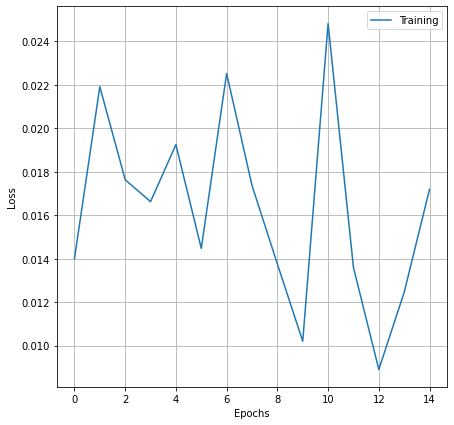

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

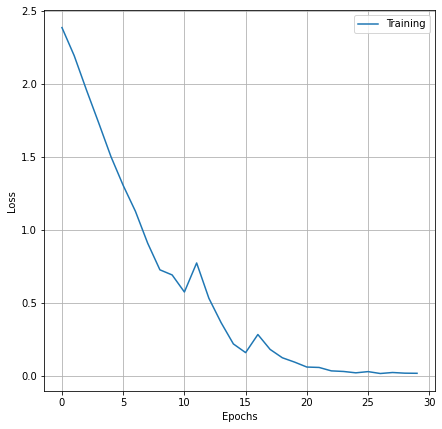

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

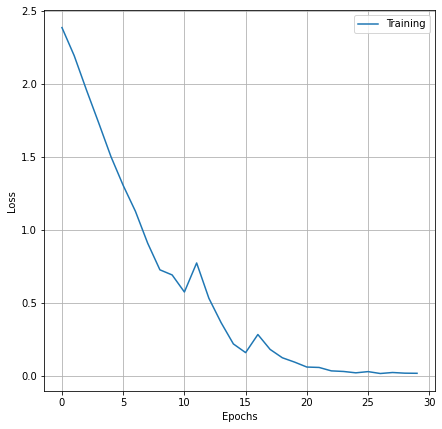

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

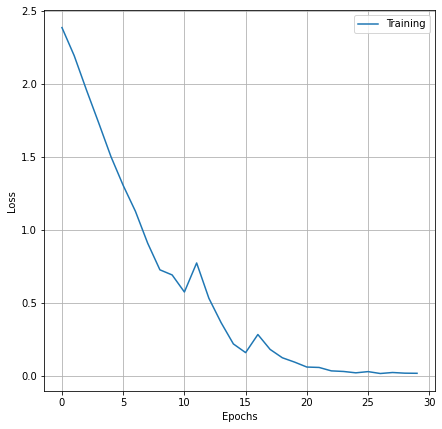

In [ ]:
plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(7,7))
plt.grid()
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("loss_curve.pdf")
plt.show()

plt.figure(figsize=(5,5))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['acc'])
#plt.plot(history.history['val_acc'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training','Validation'])
plt.savefig("acc_curve.pdf")
plt.show()

# Validation

In [ ]:
# load best weights
model.load_weights(filepath)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

OSError: ignored

In [ ]:
Xtest = Xtest.reshape(-1, windowSize, windowSize, K, 1)
Xtest.shape

In [ ]:
ytest = np_utils.to_categorical(ytest)
ytest.shape

In [ ]:
Y_pred_test = model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

In [ ]:
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [ ]:
def reports (X_test,y_test,name):
    #start = time.time()
    Y_pred = model.predict(X_test)
    y_pred = np.argmax(Y_pred, axis=1)
    #end = time.time()
    #print(end - start)
    if name == 'IP':
        target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    elif name == 'SA':
        target_names = ['Brocoli_green_weeds_1','Brocoli_green_weeds_2','Fallow','Fallow_rough_plow','Fallow_smooth',
                        'Stubble','Celery','Grapes_untrained','Soil_vinyard_develop','Corn_senesced_green_weeds',
                        'Lettuce_romaine_4wk','Lettuce_romaine_5wk','Lettuce_romaine_6wk','Lettuce_romaine_7wk',
                        'Vinyard_untrained','Vinyard_vertical_trellis']
    elif name == 'PU':
        target_names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']
    
    classification = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(y_test, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)
    score = model.evaluate(X_test, y_test, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100

In [ ]:
classification, confusion, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(Xtest,ytest,dataset)
classification = str(classification)
confusion = str(confusion)
file_name = "classification_report.txt"

with open(file_name, 'w') as x_file:
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

In [ ]:
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    
    return patch

In [ ]:
# load the original image
X, y = loadData(dataset)

In [ ]:
height = y.shape[0]
width = y.shape[1]
PATCH_SIZE = windowSize
numComponents = K

In [ ]:
X,pca = applyPCA(X, numComponents=numComponents)

In [ ]:
X = padWithZeros(X, PATCH_SIZE//2)

In [ ]:
# calculate the predicted image
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(y[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(X,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1

In [ ]:
ground_truth = spectral.imshow(classes = y,figsize =(7,7))

In [ ]:
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))

In [ ]:
spectral.save_rgb("predictions.jpg", outputs.astype(int), colors=spectral.spy_colors)

spectral.save_rgb(str(dataset)+"_ground_truth.jpg", y, colors=spectral.spy_colors)